In [1]:
import numpy as np
from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs


podatci sintetički MAKE MOONS

In [2]:
X, y = datasets.make_moons(n_samples=200, noise=0.05, random_state=42)
# broj točaka
n = X.shape[0]  

## 1. affinity/similarity matrix


In [3]:
# init. adjacency marticu 
A = np.zeros((n, n)) 

# moram napraviti matricu s euclidian udaljenostima
dists = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n): 
        dist = np.sqrt(np.sum((X[i] - X[j]) ** 2)) 
        dists[i, j] = dist
        dists[j, i] = dist 
k=10
        
## kk-nn metoda       
for i in range(n):
    neighbors = np.argsort(dists[i])[1:k+1] 
    for j in neighbors:
        A[i][j] = np.exp(-dists[i][j]**2 / 0.1) 
        A[j][i] = A[i][j]
# pripaziti da su na dijagonali 0
np.fill_diagonal(A, 0)



# RBF metoda
""" for i in range(n):
    neighbors = np.argsort(dists[i])[1:k+1] 
    for j in range(n):
        # RBF similarity function
        ##A[i,j] = np.exp(-np.sum((X[i] - X[j])**2) / (2 * sigma**2))
        # RBF krenel with euclidian distance
        dist_ij = np.sqrt(np.sum((X[i] - X[j]) ** 2)) 
        A[i,j] = np.exp(-1.0 * dist_ij ** 2)  """


""" - more controlled decay
    - exponential decay: udaljenije točke imaju jako nisu razinu sličnosti
    - sigma utječe na brzinu smanjenja sličnosti kako se euk.dist povećava
        - malena sigma: sličnost pada brzo kako se distanca povećava
        - velik sigma: sličnost se smanjuje sporo - udaljenije točke i dalje
          imaju veliku sličnost"""

' - more controlled decay\n    - exponential decay: udaljenije točke imaju jako nisu razinu sličnosti\n    - sigma utječe na brzinu smanjenja sličnosti kako se euk.dist povećava\n        - malena sigma: sličnost pada brzo kako se distanca povećava\n        - velik sigma: sličnost se smanjuje sporo - udaljenije točke i dalje\n          imaju veliku sličnost'

## 2. degree matrix

In [4]:
# trebamo matricu koja je suma redaka od ajd
D = np.zeros((n, n))  
for i in range(n):
    D[i, i] = np.sum(A[i]) 


3. un-normalized laplacian

In [5]:
L = D - A
""" dijagonalni elementi matrice su stupnjevi čvorova, a ne-dijagonalni elementi 
"""
# https://freedium.cfd/https://medium.com/@roiyeho/spectral-clustering-50aee862d300


# normalized laplacian
""" D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))  # D^(-1/2)
L = D_inv_sqrt @ L @ D_inv_sqrt """

' D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))  # D^(-1/2)\nL = D_inv_sqrt @ L @ D_inv_sqrt '

4. eigenvalues/ eigenvectors

In [6]:
# preko built in funkcije
eigvals, eigvecs = np.linalg.eig(L)
#print("Eigenvalues:", eigvals)
#print("Eigenvectors:", eigvecs)

# det(L -I*lambda) = 0  karakteristični polinomial čija su rješenja lambda1, lambda2...
# riješiti (L - lambda*I) v = 0 za svaku lambdu/eigenvrijednost

# uzimam drugi najmanji fiedlerov vektor na temelju kojeg dijelim
fiedler_vector = eigvecs[:, 1]

5. visualization

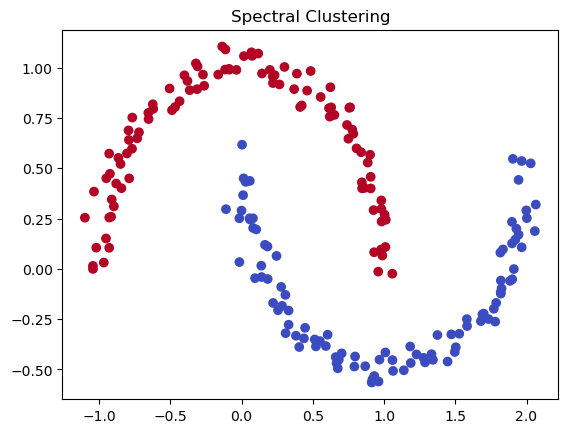

In [7]:
# dijelim podatke u ovisnosti o pozitivnosti/negativnosti
clusters = np.where(fiedler_vector >= 0, 1, 0)

# vizualizacija
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="coolwarm")
plt.title("Spectral Clustering")
plt.show()

primjer za usporedbu sa built-in metodom SpectralClustering

c:\Users\mestr\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


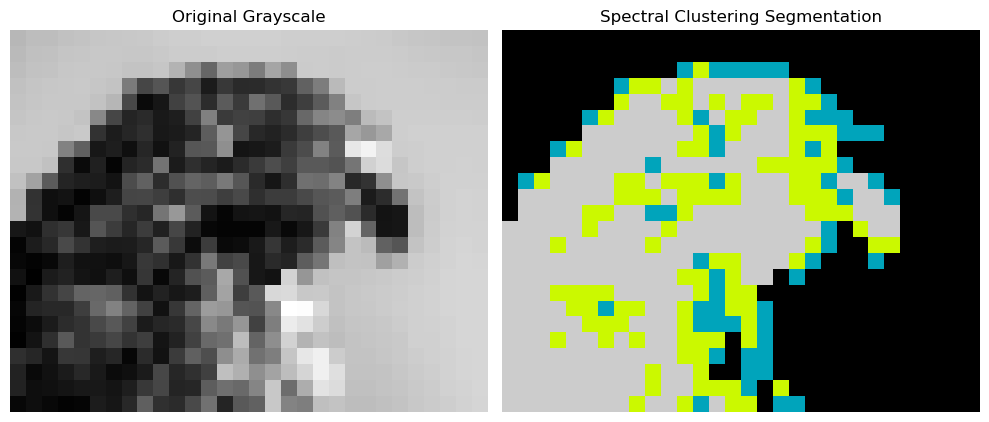

In [1]:
import numpy as np
from skimage import io, color
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
import time

def load_grayscale_image(path):
    img = io.imread(path, as_gray=True).astype(np.float64)
    if img.ndim == 3:
        img = color.rgb2gray(img)
    img = (img * 255).astype(np.uint8)  # Scale to 0–255
    img = img[:64, :64] 
    return img

def create_affinity_matrix(img, gamma_s=0.001, gamma_i=0.01):

    h, w = img.shape
    coords = np.indices((h, w)).reshape(2, -1).T
    intensities = img.flatten().reshape(-1, 1)

    spatial_sim = rbf_kernel(coords, coords, gamma=gamma_s)
    intensity_sim = rbf_kernel(intensities, intensities, gamma=gamma_i)

    affinity = spatial_sim * intensity_sim

    return affinity


def spectral_segment(img, n_clusters=8):
    affinity = create_affinity_matrix(img)
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
    labels = clustering.fit_predict(affinity)
    return labels.reshape(img.shape)


img_path = 'images/eagle_30px.png'  
img = load_grayscale_image(img_path)
segmented = spectral_segment(img, n_clusters=4)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Grayscale")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Spectral Clustering Segmentation")
plt.imshow(segmented, cmap='nipy_spectral')
plt.axis('off')
plt.tight_layout()
plt.show() ; 

Broj povezanih komponenti: 1
[[ 0.66 -0.14 -0.14 -0.02 -0.37 -0.   -0.   -0.   -0.   -0.  ]
 [-0.14  0.82 -0.02 -0.14 -0.37 -0.14 -0.   -0.02 -0.   -0.01]
 [-0.14 -0.02  0.66 -0.14 -0.37 -0.   -0.   -0.   -0.   -0.  ]
 [-0.02 -0.14 -0.14  0.82 -0.37 -0.02 -0.   -0.14 -0.   -0.01]
 [-0.37 -0.37 -0.37 -0.37  1.49 -0.01 -0.   -0.01 -0.   -0.  ]
 [-0.   -0.14 -0.   -0.02 -0.01  0.82 -0.14 -0.14 -0.02 -0.37]
 [-0.   -0.   -0.   -0.   -0.   -0.14  0.66 -0.02 -0.14 -0.37]
 [-0.   -0.02 -0.   -0.14 -0.01 -0.14 -0.02  0.82 -0.14 -0.37]
 [-0.   -0.   -0.   -0.   -0.   -0.02 -0.14 -0.14  0.66 -0.37]
 [-0.   -0.01 -0.   -0.01 -0.   -0.37 -0.37 -0.37 -0.37  1.49]]
eigenvalues:  [0.   0.11 0.68 0.69 0.75 0.86 0.93 1.11 1.86 1.88]
eigenvectors:  [[-0.32 -0.37 -0.35  0.38  0.47 -0.3   0.32 -0.17 -0.16 -0.15]
 [-0.32 -0.24  0.35  0.32  0.17  0.39 -0.38  0.47 -0.16 -0.19]
 [-0.32 -0.37 -0.35 -0.38 -0.47 -0.3  -0.32  0.17 -0.16 -0.15]
 [-0.32 -0.24  0.35 -0.32 -0.17  0.39  0.38 -0.47 -0.16 -0.19]
 [-0.32

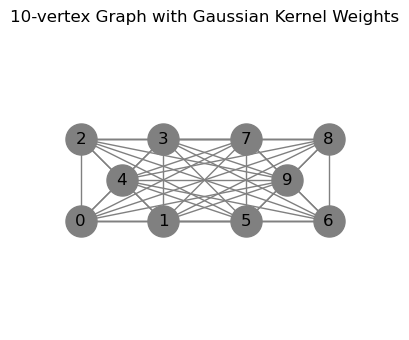

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

# Step 1: Create 10 random points in 2D space
np.random.seed(5)

points = np.array([
    [1, 1], [2, 1], [1, 2], [2, 2], [1.5, 1.5],
    [3, 1], [4, 1], [3, 2], [4, 2], [3.5, 1.5]  # bliže skupina B
])


n = len(points)
# Step 2: Compute pairwise distances
distances = squareform(pdist(points))

# Step 3: Compute affinity matrix using Gaussian (RBF) kernel
sigma = 0.5
W = np.exp(-distances**2 / (2 * sigma**2))
np.fill_diagonal(W, 0)  # zero diagonal for no self-loops


# Visualization: Plot graph
G =nx.complete_graph(10)
print("Broj povezanih komponenti:", nx.number_connected_components(G))

for i in range(n):
    G.add_node(i, pos=points[i])
for i in range(n):
    for j in range(i + 1, n):
        if W[i, j] > 0.1:
            G.add_edge(i, j, weight=W[i, j])

# Step 4: Compute degree matrix
D = np.diag(W.sum(axis=1))

# Step 5: Compute Laplacian matrix
L = D - W

# Step 6: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(L)

L, eigenvalues[:5], eigenvectors[:, :3]  # Return Laplacian, first 5 eigenvalues, and first 3 eigenvectors
print(np.round(L, 2))
print('eigenvalues: ', np.round(eigenvalues, 2))
print('eigenvectors: ', np.round(eigenvectors, 2))

pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(3, 3))
nx.draw(G, pos, with_labels=True, node_color='gray', edge_color='gray', node_size=500)
plt.title("10-vertex Graph with Gaussian Kernel Weights")
plt.axis('equal')
plt.show()


W:  [[0.    0.135 0.135 0.018 0.368 0.    0.    0.    0.    0.   ]
 [0.135 0.    0.018 0.135 0.368 0.135 0.    0.018 0.    0.007]
 [0.135 0.018 0.    0.135 0.368 0.    0.    0.    0.    0.   ]
 [0.018 0.135 0.135 0.    0.368 0.018 0.    0.135 0.    0.007]
 [0.368 0.368 0.368 0.368 0.    0.007 0.    0.007 0.    0.   ]
 [0.    0.135 0.    0.018 0.007 0.    0.135 0.135 0.018 0.368]
 [0.    0.    0.    0.    0.    0.135 0.    0.018 0.135 0.368]
 [0.    0.018 0.    0.135 0.007 0.135 0.018 0.    0.135 0.368]
 [0.    0.    0.    0.    0.    0.018 0.135 0.135 0.    0.368]
 [0.    0.007 0.    0.007 0.    0.368 0.368 0.368 0.368 0.   ]]
L:  [[ 0.657 -0.135 -0.135 -0.018 -0.368 -0.    -0.    -0.    -0.    -0.   ]
 [-0.135  0.818 -0.018 -0.135 -0.368 -0.135 -0.    -0.018 -0.    -0.007]
 [-0.135 -0.018  0.657 -0.135 -0.368 -0.    -0.    -0.    -0.    -0.   ]
 [-0.018 -0.135 -0.135  0.818 -0.368 -0.018 -0.    -0.135 -0.    -0.007]
 [-0.368 -0.368 -0.368 -0.368  1.485 -0.007 -0.    -0.007 -0.    -0. 

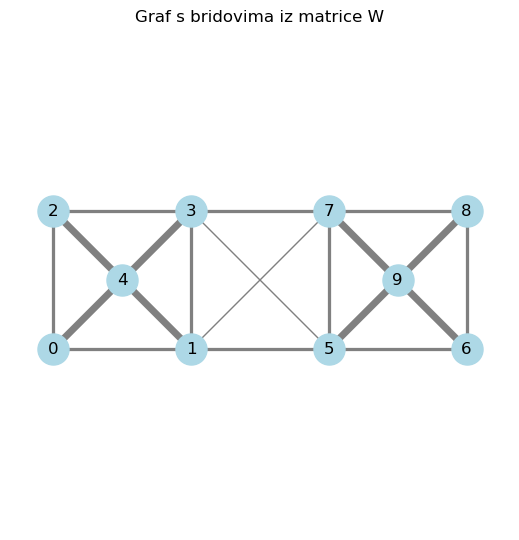

f:  [-0.374 -0.239 -0.374 -0.239 -0.325  0.239  0.374  0.239  0.374  0.325]


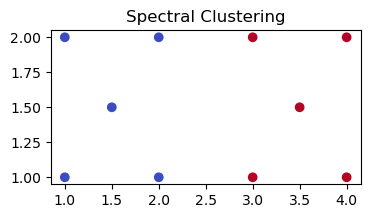

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

np.random.seed(5)

points = np.array([
    [1, 1], [2, 1], [1, 2], [2, 2], [1.5, 1.5],
    [3, 1], [4, 1], [3, 2], [4, 2], [3.5, 1.5]
])

n = len(points)
distances = squareform(pdist(points))

sigma = 0.5
W = np.exp(-distances**2 / (2 * sigma**2))
np.fill_diagonal(W, 0)
print('W: ', np.round(W,3))
""" print(np.round(W,2))
 """
# Kreiraj graf iz matrice W - samo bridovi sa težinom > 0.1
G = nx.Graph()
for i in range(n):
    G.add_node(i, pos=points[i])
for i in range(n):
    for j in range(i + 1, n):
        if W[i, j] > 0.01:
            G.add_edge(i, j, weight=W[i, j])

""" print("Broj povezanih komponenti:", nx.number_connected_components(G))
 """
# Laplacian matrica iz W
D = np.diag(W.sum(axis=1))
L = D - W
print('L: ', np.round(L,3))
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
eigenvalues, eigenvectors = eigh(L)
min_width, max_width = 1, 5
min_w, max_w = min(weights), max(weights)
edge_widths = [min_width + (w - min_w) / (max_w - min_w) * (max_width - min_width) for w in weights]

""" print(np.round(L, 2))
print('Eigenvalues:', np.round(eigenvalues, 3)) """
print(' vlastita vektora:\n', np.round(eigenvectors, 3))

pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(5, 5))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', width=edge_widths, node_size=500)
plt.title("Graf s bridovima iz matrice W")
plt.axis('equal')
plt.show() 

f = eigenvectors[:, 1]
print('f: ', np.round(f,3))
clusters = np.where(f >= 0, 1, 0)

# vizualizacija
plt.figure(figsize=(4, 2))
plt.scatter(points[:, 0], points[:, 1], c=clusters, cmap="coolwarm")
plt.title("Spectral Clustering")
plt.show()
